In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from glob import glob
import cv2
from tqdm.auto import tqdm
import os

gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu,enable=True)

In [2]:
DATA_DIR=r'C:/Users/2103099/Documents//kaggle_fungi/'
# for Colab
# DATA_DIR='./Omniglot'

train_data_path = os.path.join(DATA_DIR, "source/source/")
val_data_path = os.path.join(DATA_DIR, "target_s/target_s/")

batch_size = 32
val_batch_size = 20
epochs = 20
inner_lr = 0.02

n_way = 3
k_shot = 5
q_query = 1

input_shape = (64, 64, 1)
outer_lr = 0.0001

val_data_path 

'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s/'

In [3]:
# training v.s test Omniglot classes
source_classes = glob(DATA_DIR+'source/source/*')
target_classes = glob(DATA_DIR+'/target_s/target_s/*')
print(f'字符種類 train: test = {len(source_classes)} : {len(target_classes)}')

字符種類 train: test = 300 : 110


In [4]:

# dataset 結構: images_background/語言/字符id
source_classes[:1]

target_classes [:1]

['C:/Users/2103099/Documents//kaggle_fungi//target_s/target_s\\10000_Abortiporus_biennis']

In [5]:
def __init__(self, data_path, batch_size, n_way=5, k_shot=3, q_query=1):
    """
    :param data_path: 資料夾下有子資料夾
    :param batch_size: 一個批次有多少個不同的task
    :param n_way: 一個task有幾類
    :param k_shot: 一個類別中有幾張圖片用於inner loop training
    :param q_query: 一個類別中有幾張圖片用於outer loop training
    """
    self.file_list = [f for f in glob(data_path + "**/*", recursive=True)]
    self.steps = len(self.file_list) // batch_size

    self.n_way = n_way
    self.k_shot = k_shot
    self.q_query = q_query
    self.meta_batch_size = batch_size

In [6]:
file_list = [f for f in glob(train_data_path + "**/?????_*", recursive=True)]
# file_list = [f for f in glob(val_data_path + "*/*", recursive=True)]
print(len(file_list))


steps = len(file_list) // batch_size
print(steps)



img_dirs = random.sample(file_list, 3)

print(len(img_dirs))
# # support_image = []
# # support_label = []
# # query_image = []
# # query_label = []



n_way = 3
k_shot = 4
q_query = 1
for label, img_dir in enumerate(img_dirs):
    print("imgdir",img_dir)
    img_list = [f for f in glob(img_dir + "**/*.JPG", recursive=True)]
    print(len(img_list))
    images = random.sample(img_list, k_shot + q_query)
    print(images)

300
9
3
imgdir C:/Users/2103099/Documents//kaggle_fungi/source/source\12315_Cortinarius_bolaris
10
['C:/Users/2103099/Documents//kaggle_fungi/source/source\\12315_Cortinarius_bolaris\\MC2017-9204216_Hy54FFHO-.JPG', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\12315_Cortinarius_bolaris\\TAN2017-9218319_ry_7hbti-.JPG', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\12315_Cortinarius_bolaris\\APE2017-9202361_ryel59fqwZ.JPG', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\12315_Cortinarius_bolaris\\PETRA2017-9208117_BJLXDAKtZ.JPG', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\12315_Cortinarius_bolaris\\SVEND2011PIC86547885.JPG']
imgdir C:/Users/2103099/Documents//kaggle_fungi/source/source\60713_Parasola_auricoma
10
['C:/Users/2103099/Documents//kaggle_fungi/source/source\\60713_Parasola_auricoma\\BWP2012PIC87714842.JPG', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\60713_Parasola_auricoma\\PEL2012PIC46396265.JPG', 'C:/Users/2103099/D

In [7]:
img_dirs

['C:/Users/2103099/Documents//kaggle_fungi/source/source\\12315_Cortinarius_bolaris',
 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\60713_Parasola_auricoma',
 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\16617_Lyophyllum_decastes']

In [8]:
img_dir

'C:/Users/2103099/Documents//kaggle_fungi/source/source\\16617_Lyophyllum_decastes'

In [9]:
class MetaDataLoader:
    def __init__(self, data_path, batch_size, n_way=5, k_shot=1, q_query=1):
        """
        :param data_path: 資料夾下有子資料夾
        :param batch_size: 一個批次有多少個不同的task
        :param n_way: 一個task有幾類
        :param k_shot: 一個類別中有幾張圖片用於inner loop training
        :param q_query: 一個類別中有幾張圖片用於outer loop training
        """
        self.file_list = [f for f in glob(data_path + "**/?????_*", recursive=True)]
        self.steps = len(self.file_list) // batch_size

        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.meta_batch_size = batch_size

    def get_one_task_data(self):
        """
        取一個task, 有n_way類別,每類別有 k_shot於inner training, q_query張於outer training
        :return: support_data, query_data
        """
        img_dirs = random.sample(self.file_list, self.n_way)
        support_data = []
        query_data = []

        support_image = []
        support_label = []
        query_image = []
        query_label = []

        for label, img_dir in enumerate(img_dirs):
            img_list = [f for f in glob(img_dir + "**/*.JPG", recursive=True)]
            images = random.sample(img_list, self.k_shot + self.q_query)

            # Read support set
            for img_path in images[:self.k_shot]:
                image = cv2.imread(img_path)
                image = cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = np.expand_dims(image, axis=-1)
                support_data.append((image, label))

            # Read query set
            for img_path in images[self.k_shot:]:
                image = cv2.imread(img_path)
                image = cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = np.expand_dims(image, axis=-1)
                query_image.append(image)
                query_label.append(label)

        # shuffle support set
        random.shuffle(support_data)
        for data in support_data:
            support_image.append(data[0])
            support_label.append(data[1])

        # shuffle query set
        random.shuffle(query_data)
        for data in query_data:
            query_image.append(data[0])
            query_label.append(data[1])

        return np.array(support_image), np.array(support_label), np.array(query_image), np.array(query_label)

    def get_one_batch(self):
        """
        取一個batch, 以task為個體
        :return: k_shot_data, q_query_data
        """

        while True:
            batch_support_image = []
            batch_support_label = []
            batch_query_image = []
            batch_query_label = []

            for _ in range(self.meta_batch_size):
                support_image, support_label, query_image, query_label = self.get_one_task_data()
                batch_support_image.append(support_image)
                batch_support_label.append(support_label)
                batch_query_image.append(query_image)
                batch_query_label.append(query_label)

            yield np.array(batch_support_image), np.array(batch_support_label), \
                  np.array(batch_query_image), np.array(batch_query_label)

train_loader = MetaDataLoader(train_data_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)
val_loader = MetaDataLoader(val_data_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)

In [10]:
val_loader.steps

3

In [11]:
# support_imgs, support_labels, q_imgs, q_labels = train_loader.get_one_task_data()
support_imgs, support_labels, q_imgs, q_labels = val_loader.get_one_task_data()

In [12]:
support_labels

array([0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 1])

In [13]:
support_imgs.shape

(12, 64, 64, 1)

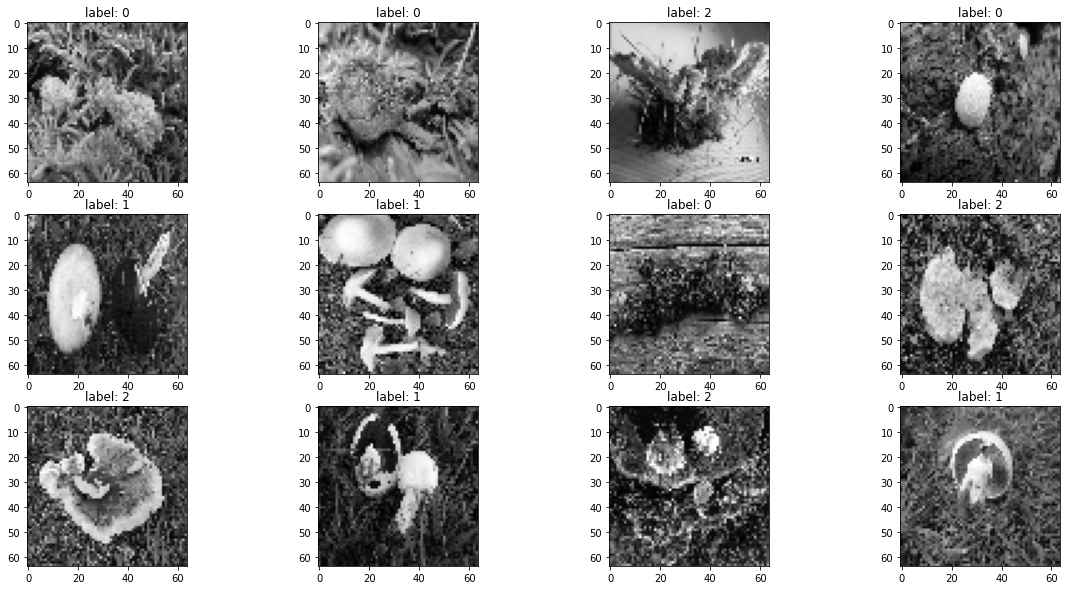

In [14]:

plt.figure(figsize=(20, 10))
for i in range(len(support_imgs)):
    plt.subplot(3, 4, i+1)
    plt.title(f'label: {support_labels[i]}')
    plt.imshow(support_imgs[i, :, :, 0], cmap='gray')
plt.show()


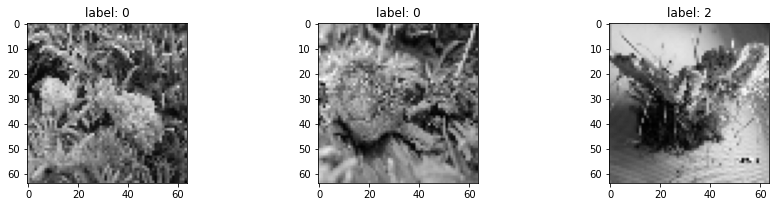

In [15]:

plt.figure(figsize=(20, 10))
for i in range(len(q_imgs)):
    plt.subplot(3, 4, i+1)
    plt.title(f'label: {support_labels[i]}')
    plt.imshow(support_imgs[i, :, :, 0], cmap='gray')
plt.show()


In [16]:

def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    return x


inputs = layers.Input(shape=(64, 64, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)

x = layers.Flatten()(x)
outputs = layers.Dense(n_way, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


inner_optimizer = keras.optimizers.Adam(learning_rate=inner_lr)
outer_optimizer = keras.optimizers.Adam(learning_rate=outer_lr)

model.compile(optimizer=inner_optimizer, 
              loss=keras.losses.sparse_categorical_crossentropy)

In [17]:
def maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True):
    meta_support_image, meta_support_label, meta_query_image, meta_query_label = next(batch_data)
    batch_acc = []
    batch_loss = []

    for support_image, support_label, query_image, query_label in zip(meta_support_image, meta_support_label, meta_query_image, meta_query_label):
        # 保存一開始model weights
        meta_weights = model.get_weights()

        # inner loop training
        for _ in range(inner_step):
            with tf.GradientTape() as tape:
                logits = model(support_image, training=True)
                loss = keras.losses.sparse_categorical_crossentropy(support_label, logits)
                loss = tf.reduce_mean(loss)
            grads = tape.gradient(loss, model.trainable_variables)
            inner_optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # outer loop training: 計算query set loss
        with tf.GradientTape() as tape:
            logits = model(query_image, training=True)
            loss = keras.losses.sparse_categorical_crossentropy(query_label, logits)
            loss = tf.reduce_mean(loss)
            acc = (np.argmax(logits, -1) == query_label).astype(np.int32).mean()

            batch_loss.append(loss)
            batch_acc.append(acc)
        # 回復成一開始weights
        model.set_weights(meta_weights)
        
        
        # 在training set中需要更新 meta model
        if training:
            grads = tape.gradient(loss, model.trainable_variables)
            outer_optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return np.array(batch_loss).mean(), np.array(batch_acc).mean()



In [18]:
val_loader.steps

3

In [19]:
val_meta_loss = []
val_meta_acc = []
# Validation
for i in range(val_loader.steps):
    batch_data = val_loader.get_one_batch()
    batch_val_loss, batch_val_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=False)
    val_meta_loss.append(batch_val_loss)
    val_meta_acc.append(batch_val_acc)
print(val_meta_acc,val_meta_loss)

[0.34375, 0.3333333333333333, 0.34375] [6.0275264, 6.2711644, 6.5206766]


In [20]:
batch_data = val_loader.get_one_batch()
 
maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=3, training=True)

(3.438098, 0.34375)

In [21]:
train_meta_loss = []
train_meta_acc = []
val_meta_loss = []
val_meta_acc = []

for meta_iter in tqdm(range(epochs)):
    # Training
    for i in tqdm(range(train_loader.steps), leave=False):
        batch_data = train_loader.get_one_batch() # batch_sup_img, batch_sup_label, batch_query_img, batch_query_label
        batch_train_loss, batch_train_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True)
        train_meta_loss.append(batch_train_loss)
        train_meta_acc.append(batch_train_acc)
    # Validation
    for i in range(val_loader.steps):
        batch_data = val_loader.get_one_batch()
        batch_val_loss, batch_val_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=3, training=False)
        val_meta_loss.append(batch_val_loss)
        val_meta_acc.append(batch_val_acc)
    print(f'[epoch {meta_iter:05d}]: train_loss: {np.mean(train_meta_loss):.4f} val_loss: {np.mean(val_meta_loss):.4f} train_acc: {np.mean(train_meta_acc):.3f} val_acc: {np.mean(val_meta_acc):.3f}')


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00000]: train_loss: 7.6886 val_loss: 3.6760 train_acc: 0.336 val_acc: 0.337


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00001]: train_loss: 4.7129 val_loss: 3.8208 train_acc: 0.339 val_acc: 0.347


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00002]: train_loss: 3.6535 val_loss: 4.0824 train_acc: 0.343 val_acc: 0.344


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00003]: train_loss: 3.1426 val_loss: 4.1532 train_acc: 0.342 val_acc: 0.348


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00004]: train_loss: 2.8276 val_loss: 4.2024 train_acc: 0.344 val_acc: 0.344


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00005]: train_loss: 2.6170 val_loss: 4.2169 train_acc: 0.343 val_acc: 0.349


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00006]: train_loss: 2.4556 val_loss: 4.2674 train_acc: 0.345 val_acc: 0.351


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00007]: train_loss: 2.3437 val_loss: 4.2948 train_acc: 0.347 val_acc: 0.353


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00008]: train_loss: 2.2603 val_loss: 4.3333 train_acc: 0.346 val_acc: 0.352


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00009]: train_loss: 2.1935 val_loss: 4.3559 train_acc: 0.345 val_acc: 0.354


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00010]: train_loss: 2.1435 val_loss: 4.3539 train_acc: 0.343 val_acc: 0.352


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00011]: train_loss: 2.0933 val_loss: 4.3669 train_acc: 0.342 val_acc: 0.352


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00012]: train_loss: 2.0432 val_loss: 4.3794 train_acc: 0.341 val_acc: 0.349


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00013]: train_loss: 2.0027 val_loss: 4.3816 train_acc: 0.340 val_acc: 0.348


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00014]: train_loss: 1.9720 val_loss: 4.3726 train_acc: 0.341 val_acc: 0.349


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00015]: train_loss: 1.9393 val_loss: 4.3959 train_acc: 0.341 val_acc: 0.351


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00016]: train_loss: 1.9125 val_loss: 4.4146 train_acc: 0.342 val_acc: 0.351


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00017]: train_loss: 1.8854 val_loss: 4.4268 train_acc: 0.342 val_acc: 0.350


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00018]: train_loss: 1.8668 val_loss: 4.4273 train_acc: 0.342 val_acc: 0.351


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00019]: train_loss: 1.8505 val_loss: 4.4359 train_acc: 0.341 val_acc: 0.351


In [26]:
# backup model weights
w = model.get_weights()
model.set_weights(w)


In [22]:

# read kaggle test1.csv file row by row
import csv
with open (r'C:/Users/2103099/Documents//kaggle_fungi/test1.csv',newline='') as csvfile:
    rows = csv.reader(csvfile)

    for row in rows:
        # restore model weights at the begining of adaptation
        model.set_weights(w)
#         print(row[0])
#         # each row is a task (3 way 1 shot) for adaptation
#         # read imgs and label (support_0: class 0, support_1: class 1, support_2: class 2)
        imgs, labels = (row[0],row[1:4])
        print(row[1:4])
#         # update model N times by (imgs, labels)

#         # use adapted model to predict img in "filename" column
        y_pred = model.predict(img_filename)
#         # get predict class and save to submission file

    

['support_0', 'support_1', 'support_2']
['11085_Xerocomellus_porosporus', '10994_Basidioradulum_radula', '15527_Inonotus_obliquus']
['67478_Lentinus_substrictus', '14845_Hygrocybe_insipida', '14815_Hygrocybe_acutoconica']
['15626_Laccaria_bicolor', '15584_Kretzschmaria_deusta', '20033_Russula_parazurea']
['63575_Chlorophyllum_olivieri', '13504_Reticularia_lycoperdon', '63478_Amanita_phalloides']
['13790_Entoloma_undatum', '16647_Macrocystidia_cucumis', '13504_Reticularia_lycoperdon']
['19653_Ramaria_botrytis', '67374_Gymnopus_perforans', '65211_Paxillus_ammoniavirescens']
['20090_Russula_velutipes', '20051_Russula_queletii', '17233_Mycena_galericulata']
['15232_Annulohypoxylon_cohaerens', '15584_Kretzschmaria_deusta', '14914_Hygrophorus_olivaceoalbus']
['11384_Ceratiomyxa_fruticulosa', '11573_Chalciporus_piperatus', '14563_Hebeloma_radicosum']
['12753_Craterellus_tubaeformis', '15815_Lactarius_blennius', '15806_Lactarius_aurantiacus']
['13459_Encoelia_furfuracea', '30412_Hypogymnia_phy

['11711_Clavariadelphus_pistillaris', '13504_Reticularia_lycoperdon', '11573_Chalciporus_piperatus']
['11573_Chalciporus_piperatus', '11384_Ceratiomyxa_fruticulosa', '12364_Cortinarius_collinitus']
['15544_Ischnoderma_resinosum', '15584_Kretzschmaria_deusta', '67483_Picipes_tubaeformis']
['17154_Morchella_esculenta', '14778_Hydnellum_concrescens', '14799_Hydnum_rufescens']
['21155_Tricholoma_ustale', '21037_Tremella_mesenterica', '21268_Tubifera_ferruginosa']
['14863_Hygrocybe_punicea', '19009_Polyporus_tuberaster', '18792_Pithya_vulgaris']
['14160_Ganoderma_pfeifferi', '14445_Gymnopus_peronatus', '13790_Entoloma_undatum']
['11095_Hortiboletus_rubellus', '15806_Lactarius_aurantiacus', '11086_Xerocomellus_pruinatus']
['20051_Russula_queletii', '15232_Annulohypoxylon_cohaerens', '20090_Russula_velutipes']
['14158_Ganoderma_applanatum', '11384_Ceratiomyxa_fruticulosa', '11573_Chalciporus_piperatus']
['60902_Lepista_saeva', '15846_Lactarius_fluens', '15888_Lactarius_pallidus']
['17242_Myce

['11711_Clavariadelphus_pistillaris', '13459_Encoelia_furfuracea', '13504_Reticularia_lycoperdon']
['41512_Clavulina_coralloides', '43396_Lycoperdon_excipuliforme', '14778_Hydnellum_concrescens']
['15357_Inocybe_erubescens', '12494_Cortinarius_malicorius', '15421_Inocybe_mixtilis']
['14886_Hygrophoropsis_aurantiaca', '14866_Hygrocybe_reidii', '14160_Ganoderma_pfeifferi']
['20603_Steccherinum_ochraceum', '20423_Skeletocutis_amorpha', '14445_Gymnopus_peronatus']
['13459_Encoelia_furfuracea', '12780_Crepidotus_mollis', '13504_Reticularia_lycoperdon']
['63575_Chlorophyllum_olivieri', '13936_Eutypa_spinosa', '13790_Entoloma_undatum']
['19653_Ramaria_botrytis', '20019_Russula_nauseosa', '14445_Gymnopus_peronatus']
['45233_Mycena_tintinnabulum', '17924_Mucidula_mucida', '17949_Panaeolus_foenisecii']
['17534_Nectria_cinnabarina', '14577_Hebeloma_velutipes', '17924_Mucidula_mucida']
['11095_Hortiboletus_rubellus', '12780_Crepidotus_mollis', '11086_Xerocomellus_pruinatus']
['14859_Cuphophyllus_p

['14778_Hydnellum_concrescens', '10065_Agaricus_campestris', '14799_Hydnum_rufescens']
['63575_Chlorophyllum_olivieri', '63478_Amanita_phalloides', '67488_Cerioporus_squamosus']
['11822_Clitopilus_hobsonii', '17293_Mycena_rubromarginata', '11772_Infundibulicybe_gibba']
['19150_Psathyrella_multipedata', '19653_Ramaria_botrytis', '14577_Hebeloma_velutipes']
['17949_Panaeolus_foenisecii', '18492_Pholiota_lenta', '21130_Tricholoma_lascivum']
['12479_Cortinarius_largus', '18492_Pholiota_lenta', '17949_Panaeolus_foenisecii']
['67478_Lentinus_substrictus', '15806_Lactarius_aurantiacus', '67483_Picipes_tubaeformis']
['20603_Steccherinum_ochraceum', '20979_Trametes_ochracea', '14563_Hebeloma_radicosum']
['63575_Chlorophyllum_olivieri', '63478_Amanita_phalloides', '17534_Nectria_cinnabarina']
['15527_Inonotus_obliquus', '67478_Lentinus_substrictus', '67483_Picipes_tubaeformis']
['16647_Macrocystidia_cucumis', '14886_Hygrophoropsis_aurantiaca', '16620_Lyophyllum_fumosum']
['15233_Hypoxylon_fragif

['17242_Mycena_inclinata', '17233_Mycena_galericulata', '10000_Abortiporus_biennis']
['13790_Entoloma_undatum', '63641_Hygrocybe_miniata', '63575_Chlorophyllum_olivieri']
['60939_Sarcomyxa_serotina', '12494_Cortinarius_malicorius', '12753_Craterellus_tubaeformis']
['20312_Scytinostroma_hemidichophyticum', '14778_Hydnellum_concrescens', '20423_Skeletocutis_amorpha']
['20979_Trametes_ochracea', '20423_Skeletocutis_amorpha', '21037_Tremella_mesenterica']
['45233_Mycena_tintinnabulum', '17233_Mycena_galericulata', '17242_Mycena_inclinata']
['14886_Hygrophoropsis_aurantiaca', '63575_Chlorophyllum_olivieri', '14866_Hygrocybe_reidii']
['11822_Clitopilus_hobsonii', '17293_Mycena_rubromarginata', '17242_Mycena_inclinata']
['15421_Inocybe_mixtilis', '20021_Russula_nitida', '20019_Russula_nauseosa']
['60939_Sarcomyxa_serotina', '10000_Abortiporus_biennis', '67511_Phaeoclavulina_eumorpha']
['60778_Pholiotina_aporos', '60902_Lepista_saeva', '14849_Gliophorus_laetus']
['60778_Pholiotina_aporos', '11

['13504_Reticularia_lycoperdon', '15911_Lactarius_romagnesii', '13459_Encoelia_furfuracea']
['15911_Lactarius_romagnesii', '15888_Lactarius_pallidus', '12753_Craterellus_tubaeformis']
['14158_Ganoderma_applanatum', '13936_Eutypa_spinosa', '13790_Entoloma_undatum']
['15846_Lactarius_fluens', '67478_Lentinus_substrictus', '15888_Lactarius_pallidus']
['15911_Lactarius_romagnesii', '15915_Lactarius_rufus', '18776_Piptoporus_betulinus']
['15233_Hypoxylon_fragiforme', '15626_Laccaria_bicolor', '15232_Annulohypoxylon_cohaerens']
['14577_Hebeloma_velutipes', '15806_Lactarius_aurantiacus', '15815_Lactarius_blennius']
['18757_Physisporinus_sanguinolentus', '18492_Pholiota_lenta', '10000_Abortiporus_biennis']
['11095_Hortiboletus_rubellus', '15626_Laccaria_bicolor', '15584_Kretzschmaria_deusta']
['15888_Lactarius_pallidus', '20979_Trametes_ochracea', '15846_Lactarius_fluens']
['63641_Hygrocybe_miniata', '14799_Hydnum_rufescens', '14815_Hygrocybe_acutoconica']
['30412_Hypogymnia_physodes', '11095_

['12780_Crepidotus_mollis', '21130_Tricholoma_lascivum', '21037_Tremella_mesenterica']
['19009_Polyporus_tuberaster', '19150_Psathyrella_multipedata', '10000_Abortiporus_biennis']
['17293_Mycena_rubromarginata', '12494_Cortinarius_malicorius', '17534_Nectria_cinnabarina']
['11095_Hortiboletus_rubellus', '11202_Buglossoporus_quercinus', '17924_Mucidula_mucida']
['15815_Lactarius_blennius', '14886_Hygrophoropsis_aurantiaca', '15828_Lactarius_controversus']
['15888_Lactarius_pallidus', '15846_Lactarius_fluens', '14799_Hydnum_rufescens']
['20603_Steccherinum_ochraceum', '15527_Inonotus_obliquus', '15544_Ischnoderma_resinosum']
['16647_Macrocystidia_cucumis', '16580_Lycogala_epidendrum', '16694_Mycetinis_alliaceus']
['18757_Physisporinus_sanguinolentus', '14845_Hygrocybe_insipida', '14815_Hygrocybe_acutoconica']
['14799_Hydnum_rufescens', '16694_Mycetinis_alliaceus', '17154_Morchella_esculenta']
['11095_Hortiboletus_rubellus', '14158_Ganoderma_applanatum', '14160_Ganoderma_pfeifferi']
['123

['21130_Tricholoma_lascivum', '21155_Tricholoma_ustale', '11234_Calocera_viscosa']
['14563_Hebeloma_radicosum', '11086_Xerocomellus_pruinatus', '11095_Hortiboletus_rubellus']
['18757_Physisporinus_sanguinolentus', '15544_Ischnoderma_resinosum', '18492_Pholiota_lenta']
['67483_Picipes_tubaeformis', '17534_Nectria_cinnabarina', '17293_Mycena_rubromarginata']
['15846_Lactarius_fluens', '14667_Hericium_coralloides', '15828_Lactarius_controversus']
['63641_Hygrocybe_miniata', '15357_Inocybe_erubescens', '15355_Inocybe_dulcamara']
['16694_Mycetinis_alliaceus', '16647_Macrocystidia_cucumis', '12753_Craterellus_tubaeformis']
['12364_Cortinarius_collinitus', '12307_Cortinarius_barbatus', '43396_Lycoperdon_excipuliforme']
['60939_Sarcomyxa_serotina', '61168_Ampulloclitocybe_clavipes', '15846_Lactarius_fluens']
['12382_Cortinarius_croceus', '12479_Cortinarius_largus', '16620_Lyophyllum_fumosum']
['18792_Pithya_vulgaris', '10994_Basidioradulum_radula', '19009_Polyporus_tuberaster']
['17293_Mycena_

['12479_Cortinarius_largus', '17924_Mucidula_mucida', '17534_Nectria_cinnabarina']
['14563_Hebeloma_radicosum', '17949_Panaeolus_foenisecii', '14577_Hebeloma_velutipes']
['67511_Phaeoclavulina_eumorpha', '18792_Pithya_vulgaris', '10000_Abortiporus_biennis']
['15915_Lactarius_rufus', '30412_Hypogymnia_physodes', '30873_Ramalina_fastigiata']
['14866_Hygrocybe_reidii', '20603_Steccherinum_ochraceum', '14886_Hygrophoropsis_aurantiaca']
['17242_Mycena_inclinata', '14914_Hygrophorus_olivaceoalbus', '14896_Hygrophorus_discoxanthus']
['17924_Mucidula_mucida', '60778_Pholiotina_aporos', '60902_Lepista_saeva']
['12494_Cortinarius_malicorius', '12479_Cortinarius_largus', '14158_Ganoderma_applanatum']
['11202_Buglossoporus_quercinus', '12780_Crepidotus_mollis', '11234_Calocera_viscosa']
['20312_Scytinostroma_hemidichophyticum', '13790_Entoloma_undatum', '13936_Eutypa_spinosa']
['14914_Hygrophorus_olivaceoalbus', '17154_Morchella_esculenta', '15232_Annulohypoxylon_cohaerens']
['20603_Steccherinum_o

['67488_Cerioporus_squamosus', '17924_Mucidula_mucida', '67483_Picipes_tubaeformis']
['14896_Hygrophorus_discoxanthus', '15911_Lactarius_romagnesii', '15915_Lactarius_rufus']
['14778_Hydnellum_concrescens', '14667_Hericium_coralloides', '67374_Gymnopus_perforans']
['20312_Scytinostroma_hemidichophyticum', '14563_Hebeloma_radicosum', '14445_Gymnopus_peronatus']
['61168_Ampulloclitocybe_clavipes', '60939_Sarcomyxa_serotina', '12382_Cortinarius_croceus']
['15421_Inocybe_mixtilis', '17293_Mycena_rubromarginata', '17242_Mycena_inclinata']
['13504_Reticularia_lycoperdon', '14815_Hygrocybe_acutoconica', '13459_Encoelia_furfuracea']
['15355_Inocybe_dulcamara', '15357_Inocybe_erubescens', '11095_Hortiboletus_rubellus']
['11086_Xerocomellus_pruinatus', '11095_Hortiboletus_rubellus', '20021_Russula_nitida']
['14799_Hydnum_rufescens', '14914_Hygrophorus_olivaceoalbus', '15232_Annulohypoxylon_cohaerens']
['11822_Clitopilus_hobsonii', '11772_Infundibulicybe_gibba', '60939_Sarcomyxa_serotina']
['1792

['67483_Picipes_tubaeformis', '11202_Buglossoporus_quercinus', '67478_Lentinus_substrictus']
['13936_Eutypa_spinosa', '14158_Ganoderma_applanatum', '10065_Agaricus_campestris']
['45233_Mycena_tintinnabulum', '43396_Lycoperdon_excipuliforme', '14849_Gliophorus_laetus']
['13936_Eutypa_spinosa', '11772_Infundibulicybe_gibba', '13790_Entoloma_undatum']
['67511_Phaeoclavulina_eumorpha', '10000_Abortiporus_biennis', '14845_Hygrocybe_insipida']
['60778_Pholiotina_aporos', '60902_Lepista_saeva', '14445_Gymnopus_peronatus']
['11095_Hortiboletus_rubellus', '15888_Lactarius_pallidus', '11086_Xerocomellus_pruinatus']
['20019_Russula_nauseosa', '11202_Buglossoporus_quercinus', '20021_Russula_nitida']
['14577_Hebeloma_velutipes', '15888_Lactarius_pallidus', '14610_Helvella_elastica']
['20423_Skeletocutis_amorpha', '15828_Lactarius_controversus', '20312_Scytinostroma_hemidichophyticum']
['14914_Hygrophorus_olivaceoalbus', '11095_Hortiboletus_rubellus', '14896_Hygrophorus_discoxanthus']
['12364_Cortin

['43396_Lycoperdon_excipuliforme', '30873_Ramalina_fastigiata', '45233_Mycena_tintinnabulum']
['11234_Calocera_viscosa', '11384_Ceratiomyxa_fruticulosa', '14859_Cuphophyllus_pratensis']
['11234_Calocera_viscosa', '11202_Buglossoporus_quercinus', '12364_Cortinarius_collinitus']
['15888_Lactarius_pallidus', '14160_Ganoderma_pfeifferi', '15911_Lactarius_romagnesii']
['14866_Hygrocybe_reidii', '21268_Tubifera_ferruginosa', '14886_Hygrophoropsis_aurantiaca']
['15888_Lactarius_pallidus', '11384_Ceratiomyxa_fruticulosa', '11573_Chalciporus_piperatus']
['10994_Basidioradulum_radula', '10065_Agaricus_campestris', '65211_Paxillus_ammoniavirescens']
['20090_Russula_velutipes', '30412_Hypogymnia_physodes', '30873_Ramalina_fastigiata']
['10065_Agaricus_campestris', '10000_Abortiporus_biennis', '15806_Lactarius_aurantiacus']
['12382_Cortinarius_croceus', '12479_Cortinarius_largus', '65211_Paxillus_ammoniavirescens']
['18757_Physisporinus_sanguinolentus', '15357_Inocybe_erubescens', '15421_Inocybe_mi

['15421_Inocybe_mixtilis', '15357_Inocybe_erubescens', '45233_Mycena_tintinnabulum']
['20603_Steccherinum_ochraceum', '14845_Hygrocybe_insipida', '14849_Gliophorus_laetus']
['17924_Mucidula_mucida', '63641_Hygrocybe_miniata', '65211_Paxillus_ammoniavirescens']
['20019_Russula_nauseosa', '15846_Lactarius_fluens', '15828_Lactarius_controversus']
['20090_Russula_velutipes', '14896_Hygrophorus_discoxanthus', '20051_Russula_queletii']
['14859_Cuphophyllus_pratensis', '11095_Hortiboletus_rubellus', '14863_Hygrocybe_punicea']
['13790_Entoloma_undatum', '13936_Eutypa_spinosa', '20021_Russula_nitida']
['14849_Gliophorus_laetus', '17242_Mycena_inclinata', '14845_Hygrocybe_insipida']
['14815_Hygrocybe_acutoconica', '14799_Hydnum_rufescens', '67374_Gymnopus_perforans']
['15911_Lactarius_romagnesii', '16580_Lycogala_epidendrum', '15915_Lactarius_rufus']
['12780_Crepidotus_mollis', '63478_Amanita_phalloides', '61168_Ampulloclitocybe_clavipes']
['11573_Chalciporus_piperatus', '11384_Ceratiomyxa_fruti

['14886_Hygrophoropsis_aurantiaca', '45233_Mycena_tintinnabulum', '14896_Hygrophorus_discoxanthus']
['14445_Gymnopus_peronatus', '41512_Clavulina_coralloides', '14160_Ganoderma_pfeifferi']
['20979_Trametes_ochracea', '15233_Hypoxylon_fragiforme', '15355_Inocybe_dulcamara']
['45233_Mycena_tintinnabulum', '16620_Lyophyllum_fumosum', '16647_Macrocystidia_cucumis']
['63575_Chlorophyllum_olivieri', '12364_Cortinarius_collinitus', '12382_Cortinarius_croceus']
['11573_Chalciporus_piperatus', '18792_Pithya_vulgaris', '19009_Polyporus_tuberaster']
['21130_Tricholoma_lascivum', '11384_Ceratiomyxa_fruticulosa', '21037_Tremella_mesenterica']
['16580_Lycogala_epidendrum', '18757_Physisporinus_sanguinolentus', '18776_Piptoporus_betulinus']
['15515_Inocybe_whitei', '15527_Inonotus_obliquus', '17154_Morchella_esculenta']
['14849_Gliophorus_laetus', '14815_Hygrocybe_acutoconica', '14845_Hygrocybe_insipida']
['14896_Hygrophorus_discoxanthus', '17924_Mucidula_mucida', '17949_Panaeolus_foenisecii']
['1664

['13504_Reticularia_lycoperdon', '13790_Entoloma_undatum', '14610_Helvella_elastica']
['63641_Hygrocybe_miniata', '63575_Chlorophyllum_olivieri', '19653_Ramaria_botrytis']
['17293_Mycena_rubromarginata', '11573_Chalciporus_piperatus', '11711_Clavariadelphus_pistillaris']
['14815_Hygrocybe_acutoconica', '12753_Craterellus_tubaeformis', '14799_Hydnum_rufescens']
['30873_Ramalina_fastigiata', '15828_Lactarius_controversus', '30412_Hypogymnia_physodes']
['11822_Clitopilus_hobsonii', '12307_Cortinarius_barbatus', '12364_Cortinarius_collinitus']
['16647_Macrocystidia_cucumis', '67488_Cerioporus_squamosus', '67483_Picipes_tubaeformis']
['19653_Ramaria_botrytis', '20019_Russula_nauseosa', '60902_Lepista_saeva']
['43396_Lycoperdon_excipuliforme', '12780_Crepidotus_mollis', '13459_Encoelia_furfuracea']
['20423_Skeletocutis_amorpha', '20051_Russula_queletii', '20033_Russula_parazurea']
['11086_Xerocomellus_pruinatus', '11085_Xerocomellus_porosporus', '16694_Mycetinis_alliaceus']
['15355_Inocybe_d

['14849_Gliophorus_laetus', '12307_Cortinarius_barbatus', '12364_Cortinarius_collinitus']
['14160_Ganoderma_pfeifferi', '15828_Lactarius_controversus', '15846_Lactarius_fluens']
['12753_Craterellus_tubaeformis', '12780_Crepidotus_mollis', '11086_Xerocomellus_pruinatus']
['21130_Tricholoma_lascivum', '21155_Tricholoma_ustale', '60902_Lepista_saeva']
['15911_Lactarius_romagnesii', '14896_Hygrophorus_discoxanthus', '14914_Hygrophorus_olivaceoalbus']
['18792_Pithya_vulgaris', '12753_Craterellus_tubaeformis', '12494_Cortinarius_malicorius']
['14445_Gymnopus_peronatus', '21130_Tricholoma_lascivum', '21155_Tricholoma_ustale']
['17154_Morchella_esculenta', '15626_Laccaria_bicolor', '16694_Mycetinis_alliaceus']
['11384_Ceratiomyxa_fruticulosa', '11573_Chalciporus_piperatus', '20021_Russula_nitida']
['11772_Infundibulicybe_gibba', '11822_Clitopilus_hobsonii', '15357_Inocybe_erubescens']
['15355_Inocybe_dulcamara', '11384_Ceratiomyxa_fruticulosa', '11234_Calocera_viscosa']
['17233_Mycena_galericu

['21037_Tremella_mesenterica', '20021_Russula_nitida', '20033_Russula_parazurea']
['45233_Mycena_tintinnabulum', '67511_Phaeoclavulina_eumorpha', '43396_Lycoperdon_excipuliforme']
['21037_Tremella_mesenterica', '18492_Pholiota_lenta', '18757_Physisporinus_sanguinolentus']
['20051_Russula_queletii', '63478_Amanita_phalloides', '63575_Chlorophyllum_olivieri']
['15806_Lactarius_aurantiacus', '12753_Craterellus_tubaeformis', '12780_Crepidotus_mollis']
['60939_Sarcomyxa_serotina', '19653_Ramaria_botrytis', '60902_Lepista_saeva']
['10994_Basidioradulum_radula', '11085_Xerocomellus_porosporus', '15915_Lactarius_rufus']
['14863_Hygrocybe_punicea', '10065_Agaricus_campestris', '14866_Hygrocybe_reidii']
['13459_Encoelia_furfuracea', '21037_Tremella_mesenterica', '20979_Trametes_ochracea']
['20217_Scleroderma_bovista', '15846_Lactarius_fluens', '20312_Scytinostroma_hemidichophyticum']
['20217_Scleroderma_bovista', '11234_Calocera_viscosa', '20312_Scytinostroma_hemidichophyticum']
['15421_Inocybe_

['14859_Cuphophyllus_pratensis', '12753_Craterellus_tubaeformis', '12494_Cortinarius_malicorius']
['19150_Psathyrella_multipedata', '19009_Polyporus_tuberaster', '20090_Russula_velutipes']
['14866_Hygrocybe_reidii', '63575_Chlorophyllum_olivieri', '63478_Amanita_phalloides']
['12307_Cortinarius_barbatus', '30412_Hypogymnia_physodes', '11822_Clitopilus_hobsonii']
['11772_Infundibulicybe_gibba', '11711_Clavariadelphus_pistillaris', '11573_Chalciporus_piperatus']
['15626_Laccaria_bicolor', '15806_Lactarius_aurantiacus', '20979_Trametes_ochracea']
['11711_Clavariadelphus_pistillaris', '15357_Inocybe_erubescens', '11573_Chalciporus_piperatus']
['11384_Ceratiomyxa_fruticulosa', '11234_Calocera_viscosa', '14845_Hygrocybe_insipida']
['65211_Paxillus_ammoniavirescens', '12364_Cortinarius_collinitus', '12307_Cortinarius_barbatus']
['11202_Buglossoporus_quercinus', '15357_Inocybe_erubescens', '11095_Hortiboletus_rubellus']
['11772_Infundibulicybe_gibba', '15806_Lactarius_aurantiacus', '11711_Clav

['63575_Chlorophyllum_olivieri', '63478_Amanita_phalloides', '11086_Xerocomellus_pruinatus']
